In [371]:
#IMPORT LIBRARIES
import sqlite3
import os
import pandas as pd
import numpy as np
import random
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from itertools import product
from math import ceil
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline
#from pandas_profiling import ProfileReport 
%config InlineBackend.figure_format = 'retina' 
from scipy.stats import iqr as IQR
from collections import Counter
import scipy.stats as stat
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix, csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set()

Collect initial data

In [2]:
#import file csv
df = pd.read_csv('retail.csv')
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Describe, explore and assess data quality

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.replace("", np.nan, inplace=True)

In [7]:
# Summary statistics for all variables
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#FUNCTION TO SHOW MISSING VALUES AND THEIR PERCENTAGES
def missing_data(df):
    l = []
    for col in df.columns:
        missing = df[col].isnull().sum(axis=0)
        percentage = missing/df.shape[0]
        l.append([col,missing,percentage*100])
        df_missing = pd.DataFrame(l, columns = ['Feature','missing','percentage'])
        df_missing = df_missing.sort_values('missing',axis=0, ascending = False)    
    return df_missing

In [9]:
df_missing = missing_data(df)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,135080,24.926694
2,Description,1454,0.268311


In [10]:
# Check duplicated observations
df.loc[df.duplicated(keep=False), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [11]:
# Create dataframe copy
df1 = df.copy()

## Data Preparation:

### Clean data

In [12]:
# Dropduplicated rows
df1.drop_duplicates(inplace=True)

In [13]:
# Select irregular stock code values
irregular_stockcode = ['DCGS0076','DCGS0003','DCGS0070','DCGS0055', 'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057',
                       'DCGSSBOY', 'DCGSSGIRL', 'DCGS0004', 'DCGS0073', 'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P',
                       'POST', 'D', 'DOT','M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'gift_0001_40', 'gift_0001_50', 
                       'gift_0001_30', 'gift_0001_20','gift_0001_10', 'PADS', 'B', 'CRUK', 'c2','C2','m']

In [14]:
# Remove records with irregular stock code values
df1 = df1[~  df1['StockCode'].isin(irregular_stockcode)]

In [15]:
#Remove transactions with price =0.  
df1 = df1[df1['UnitPrice']>0]

In [16]:
print('Percentage of data kept after removing irregularities:', np.round(df1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing irregularities: 0.9802


In [17]:
# 'Unspecified' will be kept because it does not affect the collaborative filtering algorithm
df1['Country'].value_counts()

United Kingdom          486167
Germany                   9080
France                    8218
EIRE                      8059
Spain                     2462
Netherlands               2326
Belgium                   1971
Switzerland               1960
Portugal                  1466
Australia                 1253
Norway                    1059
Italy                      783
Channel Islands            752
Finland                    653
Cyprus                     608
Unspecified                442
Sweden                     436
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
Israel                     294
USA                        291
Hong Kong                  276
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon 

In [18]:
# Check missing data
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,131516,24.759588


In [19]:
# Get max CustomerID
idMax = df1['CustomerID'].max()

# Get distinct invoice numbers for records where CustomerID is null
invoicesNullCustomer = df1[df1['CustomerID'].isnull()]['InvoiceNo'].unique()

# fill up the records where the customer id is null, giving a new customer id for the records containing the same invoice numbers
next_customerId = idMax+1
for invoiceNo in invoicesNullCustomer:
    df1.loc[df1['InvoiceNo'] == invoiceNo, 'CustomerID'] = next_customerId
    next_customerId +=1

In [20]:
# Check missing data
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage


In [21]:
# Change 'InvoiceDate' data type to datetime, and create new column with the date respective year and month
df1['InvoiceDate'] = df1['InvoiceDate'].astype('datetime64[ns]')
df1['Month_Year'] = df1['InvoiceDate'].dt.strftime('%Y-%m')
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12


In [22]:
#Create a binary column if Invoice is a cancelation invoice or not
df1['Cancel'] = df1['InvoiceNo'].str.contains('C').astype(int)

In [23]:
# Check data info
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531172 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531172 non-null  object        
 1   StockCode    531172 non-null  object        
 2   Description  531172 non-null  object        
 3   Quantity     531172 non-null  int64         
 4   InvoiceDate  531172 non-null  datetime64[ns]
 5   UnitPrice    531172 non-null  float64       
 6   CustomerID   531172 non-null  float64       
 7   Country      531172 non-null  object        
 8   Month_Year   531172 non-null  object        
 9   Cancel       531172 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(5)
memory usage: 42.6+ MB


In [24]:
# dataframe basic value stats
df1.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
InvoiceNo,531172,23195,573585,1112,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,531172,3914,85123A,2295,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,531172,4019,WHITE HANGING HEART T-LIGHT HOLDER,2353,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,531172,NaN,NaN,NaN,NaT,NaT,9.96149,217.015,-80995,1,3,10,80995
InvoiceDate,531172,21308,2011-10-31 14:41:00,1112,2010-12-01 08:26:00,2011-12-09 12:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,531172,NaN,NaN,NaN,NaT,NaT,3.29253,4.51292,0.03,1.25,2.08,4.13,649.5
CustomerID,531172,NaN,NaN,NaN,NaT,NaT,16222,2213.44,12346,14367,16241,18260,19697
Country,531172,38,United Kingdom,486167,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Year,531172,13,2011-11,82739,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cancel,531172,NaN,NaN,NaN,NaT,NaT,0.0163186,0.126698,0,0,0,0,1


### Recomendation System


In [25]:
df1_rs = df1.copy()
df1_rs_no_cancel = df1_rs[df1_rs['Cancel']==0]
df1_rs_no_cancel

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year,Cancel
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,0
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12,0


In [26]:
# Find new users and returning customers

# distinct orders counts by each user
orders_counts = df1_rs_no_cancel.groupby('CustomerID')['InvoiceNo'].nunique()

# get new and returning customers ids
new_customers_ids = orders_counts[orders_counts == 1].index
repeat_customers_ids = orders_counts[orders_counts > 1].index

# create two dataframes, one for new customer and the other for returning customers
new_customers_df = df1_rs_no_cancel[df1_rs_no_cancel['CustomerID'].isin(new_customers_ids)]
repeat_customers_df = df1_rs_no_cancel[df1_rs_no_cancel['CustomerID'].isin(repeat_customers_ids)]

# percentage of new customers compared to all orders
print("{}% of the orders were made by customers that only bought once.".format(round(new_customers_df.shape[0]/df1_rs_no_cancel.shape[0], 2)*100)) 

32.0% of the orders were made by customers that only bought once.


In [27]:
#repeat_customers_df.to_csv(os.path.join("repeat_customers_df.csv"), index=False)

In [28]:
# Check dataframe
repeat_customers_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year,Cancel
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,0
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12,0


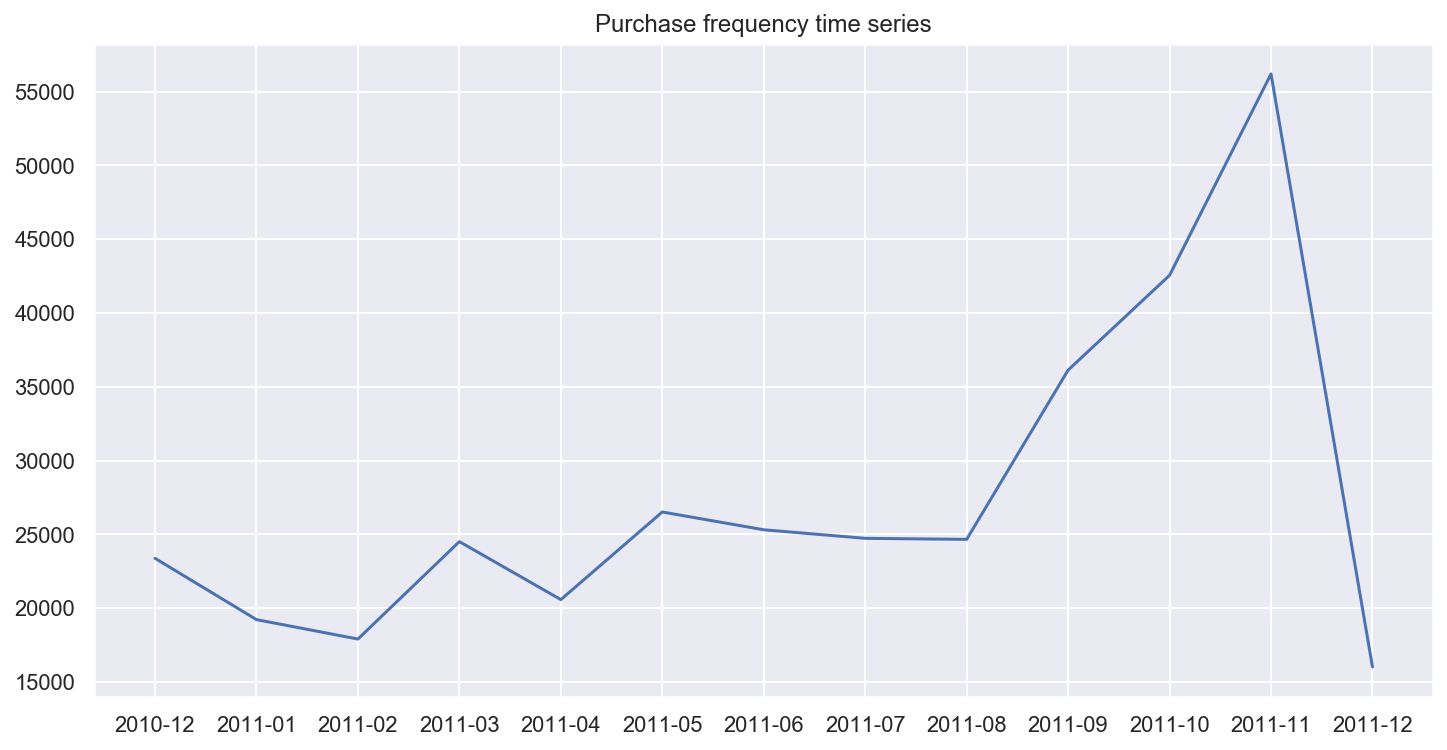

In [29]:
# Visualize number of purchases per month
purchases_per_month = repeat_customers_df['Month_Year'].value_counts().sort_index()

# Set plot
fig = plt.figure(figsize=(12,6))
plt.plot(purchases_per_month.index, purchases_per_month.values, linestyle="-")
plt.title('Purchase frequency time series')
plt.show()

### Reduce sparsity

In [30]:
# Reduce sparcity by excluding users and items without significant event history
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [31]:
# get limited dataset
df_limited = threshold_ratings(repeat_customers_df, 5, 5)

Raw dataset info 
-----------------
Number of users: 2829
Number of items: 3626
Sparsity: 3.487%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 2786
Number of items: 3118
Sparsity: 4.104%


### Train-test split

In [32]:
# Split the data in a way where the train events occour before the test events, in a ratio of 80/20
df_limited['Month_Year'].value_counts(normalize=True).sort_index() * 100

2010-12     6.499178
2011-01     5.365728
2011-02     5.001094
2011-03     6.841654
2011-04     5.744947
2011-05     7.413568
2011-06     7.080068
2011-07     6.917105
2011-08     6.899714
2011-09    10.107090
2011-10    11.922125
2011-11    15.724976
2011-12     4.482753
Name: Month_Year, dtype: float64

In [33]:
# As the last two months (2011-11 and 2011-12) account for 20.03% of all the records 
# the orders made in these months will be used for the test set

# create a train - test data flag
df_limited['train_split'] = (df_limited['Month_Year'] < '2011-11').astype(int)

# check train/test ratio
df_limited['train_split'].value_counts(normalize=True)

1    0.797923
0    0.202077
Name: train_split, dtype: float64

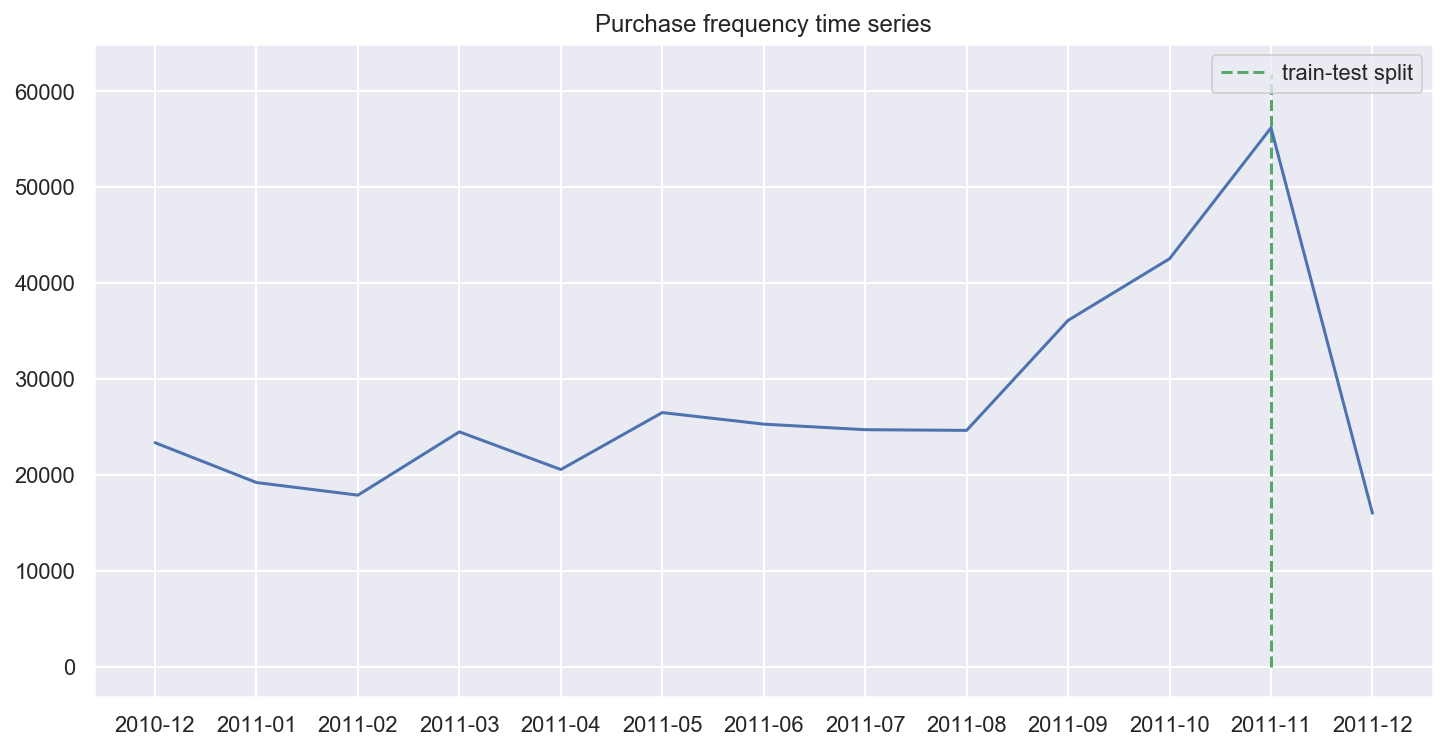

In [34]:
# Visualize the train and test dataset
purchases_per_month = repeat_customers_df['Month_Year'].value_counts().sort_index()

# Set plot
fig = plt.figure(figsize=(12,6))
plt.plot(purchases_per_month.index, purchases_per_month.values, linestyle="-")
plt.vlines(x = '2011-11', ymin= 0, ymax=purchases_per_month.max()*1.1, linestyles='dashed', color='g', label='train-test split')
plt.legend()
plt.title('Purchase frequency time series')
plt.show()

### Train and test raiting matrices

In [35]:
# create series with the customers ids and stock codes as categories
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['StockCode'].astype("category")

# create train sparse matrix 
item_user_train = coo_matrix((df_limited['train_split'], (item_cat.cat.codes, user_cat.cat.codes))).tocsr()

# remove zero entries
item_user_train.eliminate_zeros() 

# produce transpose of item_user_train
user_item_train = item_user_train.T

# create test sparse matrix 
item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                                                                                   (item_cat.cat.codes,
                                                                                    user_cat.cat.codes))).tocsr()
# remove zero entries
item_user_test.eliminate_zeros() 

# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

# Function to get dictionary keys with specifiec value
def get_keys(value, dictionary):
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (3118, 2786) and test set shape: (3118, 2786)
train set percentage of zeros: 97.76086517071751 and test set percentage of zeros: 99.3104784437168


In [36]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [37]:
# get most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['StockCode'] == item_id) & (df_limited['train_split'] == 1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year,Cancel,train_split
2095,536557,79321,CHILLI LIGHTS,24,2010-12-01 14:41:00,4.25,17841.0,United Kingdom,2010-12,0,1
6995,536984,79321,CHILLI LIGHTS,24,2010-12-03 14:35:00,4.25,17841.0,United Kingdom,2010-12,0,1
12963,537405,79321,CHILLI LIGHTS,30,2010-12-06 14:51:00,4.25,17841.0,United Kingdom,2010-12,0,1
30437,538866,79321,CHILLI LIGHTS,24,2010-12-14 14:40:00,4.25,17841.0,United Kingdom,2010-12,0,1
37526,539469,79321,CHILLI LIGHTS,24,2010-12-19 13:59:00,4.25,17841.0,United Kingdom,2010-12,0,1
42796,540021,79321,CHILLI LIGHTS,48,2011-01-04 12:51:00,4.25,17841.0,United Kingdom,2011-01,0,1
49899,540538,79321,CHILLI LIGHTS,34,2011-01-09 14:36:00,4.25,17841.0,United Kingdom,2011-01,0,1
54377,540943,79321,CHILLI LIGHTS,3,2011-01-12 12:31:00,4.95,17841.0,United Kingdom,2011-01,0,1
58579,541253,79321,CHILLI LIGHTS,30,2011-01-16 13:51:00,4.25,17841.0,United Kingdom,2011-01,0,1
63631,541587,79321,CHILLI LIGHTS,24,2011-01-19 14:39:00,4.25,17841.0,United Kingdom,2011-01,0,1


### Fit ALS (Alternating Least Squares) model

In [38]:
alpha = 40
train_conf = (item_user_train * alpha).astype('double')
als_model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=30)

als_model.fit(train_conf)

In [45]:
# test BayesianPersonalizedRanking
bpr_model = BayesianPersonalizedRanking(factors=50, regularization=0.01, iterations=30)
bpr_model.fit(train_conf)

In [50]:
# test LogisticMatrixFactorization
lmf_model = LogisticMatrixFactorization(factors=50, regularization=0.01, iterations=30)
lmf_model.fit(train_conf)

In [39]:
# Evaluation - Create a model that will predict the most populat product for each user 
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [40]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

In [51]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model, 'bpt_model': bpr_model, 'lmf_model': lmf_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model,bpt_model,lmf_model
precision,0.091631,0.052874,0.064617,0.020770
map,0.041425,0.020244,0.028627,0.006661
ndcg,0.093607,0.050652,0.065793,0.019361
auc,0.512940,0.508869,0.508908,0.500387


# Collaborative Filtering Recommender System

In [381]:
# Create dataframe grouped by users, products and summing up the quantities
# Instead of representing an explicit rating
# records with a larger number of quantity by a person can carry more weight in our ratings matrix
grouped_df = df1.groupby(['CustomerID', 'StockCode'])['Quantity'].sum() 
grouped_df = pd.DataFrame(grouped_df)
grouped_df.reset_index(inplace=True)

# Show dataframe 
grouped_df

,CustomerID,StockCode,Quantity
0,12346.0,23166,0
1,12347.0,16008,24
2,12347.0,17021,36
3,12347.0,20665,6
4,12347.0,20719,40
...,...,...,...
397970,19697.0,85049e,4
397971,19697.0,85099B,5
397972,19697.0,85099C,4
397973,19697.0,85150,1


In [382]:
# Remove rows where the quantity is 0 
grouped_df = grouped_df[grouped_df['Quantity'] > 0]

# Show dataframe
grouped_df

,CustomerID,StockCode,Quantity
1,12347.0,16008,24
2,12347.0,17021,36
3,12347.0,20665,6
4,12347.0,20719,40
5,12347.0,20780,12
...,...,...,...
397970,19697.0,85049e,4
397971,19697.0,85099B,5
397972,19697.0,85099C,4
397973,19697.0,85150,1


In [383]:
# Change column types
grouped_df['Quantity'] = grouped_df['Quantity'].astype(float)
grouped_df['CustomerID'] = grouped_df['CustomerID'].astype("category")
grouped_df['StockCode'] = grouped_df['StockCode'].astype("category")

# Create two codes columns
grouped_df['Customer_ID'] = grouped_df['CustomerID'].cat.codes
grouped_df['Stock_Code'] = grouped_df['StockCode'].cat.codes

# Show dataframe
grouped_df

,CustomerID,StockCode,Quantity,Customer_ID,Stock_Code
1,12347.0,16008,24.0,0,29
2,12347.0,17021,36.0,0,91
3,12347.0,20665,6.0,0,135
4,12347.0,20719,40.0,0,171
5,12347.0,20780,12.0,0,211
...,...,...,...,...,...
397970,19697.0,85049e,4.0,5692,3355
397971,19697.0,85099B,5.0,5692,3381
397972,19697.0,85099C,4.0,5692,3382
397973,19697.0,85150,1.0,5692,3435


In [215]:
# Create two matrices, one for fitting the model (item-user) and one for recommendations (user-item)
sparse_item_user = csr_matrix((grouped_df['Quantity'], (grouped_df['Stock_Code'], grouped_df['Customer_ID'])))
sparse_user_item = csr_matrix((grouped_df['Quantity'], (grouped_df['Customer_ID'], grouped_df['Stock_Code'])))

In [402]:
# Initialize the Alternating Least Squares (ALS) recommendation model
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

# Fit the model using the sparse content-person matrix
alpha = 15
data = (sparse_item_user * alpha).astype('double')
model.fit(data)

### Find most similar products

In [403]:
# Encoded Stock code of a product (randomly selected) 
item_id = 3381

# Number of similiar products to find (the number - 1)
n_similar = 11

# Get the customer and item vectors from trained model
user_vecs = model.user_factors
item_vecs = model.item_factors

# Calculate the vector norms
item_norms = np.sqrt((item_vecs * item_vecs).sum(axis=1))

# Calculate the similarity score
scores = item_vecs.dot(item_vecs[item_id]) /item_norms

# Get the top 10 most similar items
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]

# Create a list of content-score tuples of most similar items
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[item_id]), key=lambda x: -x[1])

In [404]:
# Get product stockcode
item_stock_code = grouped_df[grouped_df['Stock_Code'] == item_id]['StockCode'].unique()[0]

# Get product description
item_description = df1[df1['StockCode'] == item_stock_code]['Description'].unique().tolist()

# Print product description
print("Most similar products to: ", item_description[0], ":\n")

for item in similar[1:]:
    idx, score = item
    
    # get stock code of the similiar products
    stock_code = grouped_df['StockCode'].loc[grouped_df['Stock_Code'] == idx].iloc[0]
    
    # get products descriptions 
    similar_products = items[items['StockCode']==stock_code]['Description'].unique().tolist()[0]
    
    print(similar_products)

Most similar products to:  JUMBO BAG RED RETROSPOT :

JUMBO SHOPPER VINTAGE RED PAISLEY
JUMBO BAG PINK POLKADOT
JUMBO STORAGE BAG SUKI
JUMBO BAG STRAWBERRY
JUMBO  BAG BAROQUE BLACK WHITE
JUMBO BAG PINK VINTAGE PAISLEY
JUMBO BAG SCANDINAVIAN PAISLEY
RECYCLING BAG RETROSPOT 
JUMBO BAG SPACEBOY DESIGN
JUMBO STORAGE BAG SKULLS


### Recommend items to customers

In [405]:
# Create function return the top recommendations chosen based on the customer/item vectors for items never interacted 
# for items never interacted with for any given person

def recommend(user_id, sparse_user_item, user_vecs, item_vecs, num_items=10):
    
    # Get the interactions scores from the sparse user item matrix
    user_interactions = sparse_user_item[user_id, :].toarray()
    
    # Add 1 to everything, so that items with no interaction yet become equal to 1
    user_interactions = user_interactions.reshape(-1) + 1
    
    # Make items already interacted zero
    user_interactions[user_interactions > 1] = 0
    
    # Get dot product of user vector and all item vectors
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()
    
    # Scale the recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    
    # Items already interacted have their recommendation multiplied by zero
    recommend_vector = user_interactions * rec_vector_scaled
    
    # Sort the indices of the item into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1][:num_items]
    
    # Start empty list to store item descriptions and scores
    descriptions = []
    scores = []
    
    # Append descriptions and scores to the list
    for idx in content_idx:
        # get stock code of the the product
        stock_code = grouped_df['StockCode'].loc[grouped_df['Stock_Code'] == idx].iloc[0]

        # get products descriptions
        item_description = items[items['StockCode']==stock_code]['Description'].unique().tolist()[0]

        descriptions.append(item_description)
        scores.append(recommend_vector[idx])
    
    # Create dataframe with the resulting data
    recommendations = pd.DataFrame({'Descriptions': descriptions, 'score': scores})
    
    return recommendations

In [406]:
# Get the trained user and item vectors. Convert them to csr matrices
user_vecs = sparse.csr_matrix(model.user_factors)
item_vecs = sparse.csr_matrix(model.item_factors)

# Create recommendations for customer with encoded id = 1856 (randomly chosen)
user_id = 1856

# Make recomendations
recommendations = recommend(user_id, sparse_user_item, user_vecs, item_vecs)

# Print recomendations
print(recommendations)

                        Descriptions     score
0         JAZZ HEARTS PURSE NOTEBOOK  1.000000
1               SMALL POPCORN HOLDER  0.910956
2  JUMBO SHOPPER VINTAGE RED PAISLEY  0.887205
3  PACK OF 12 HEARTS DESIGN TISSUES   0.886282
4             STRAWBERRY SHOPPER BAG  0.885593
5       REX CASH+CARRY JUMBO SHOPPER  0.882193
6  WORLD WAR 2 GLIDERS ASSTD DESIGNS  0.879031
7           WOOD STAMP SET THANK YOU  0.873759
8               JUMBO BAG STRAWBERRY  0.871978
9           JAZZ HEARTS ADDRESS BOOK  0.869771


In [407]:
# Check recommendations by comparing them to the 10 items this user has most interacted  with
most_bought_items = grouped_df[grouped_df['Customer_ID'] == user_id].sort_values(by=['Quantity'], ascending=False).head(10)

# Get item descriptions based on its StockCode
description_list = []
for index, row in most_bought_items.iterrows():
    code = str(row['StockCode'])
    description_list.append(df1[df1['StockCode'] == code]['Description'].unique()[0])

# Add item descriptions to the dataframe and filter relevant columns
most_bought_items['Description'] = description_list
most_bought_items = most_bought_items[['Description', 'Quantity']]
                     
# Show the 10 items this user has most interacted  with
most_bought_items

,Description,Quantity
116455,PACK OF 12 SKULL TISSUES,48.0
116470,PACK OF 12 LONDON TISSUES,48.0
116457,PACK OF 12 SUKI TISSUES,48.0
116456,PACK OF 12 RED RETROSPOT TISSUES,48.0
116469,PENS ASSORTED FUNNY FACE,36.0
116472,GROW A FLYTRAP OR SUNFLOWER IN TIN,24.0
116464,LUNCH BAG PINK POLKADOT,20.0
116446,LUNCH BAG BLACK SKULL.,20.0
116452,ASSORTED SANSKRIT MINI NOTEBOOK,18.0
116466,PLASTERS IN TIN SKULLS,12.0


### Evaluating the Recommender system

In [396]:
# Evaluate the performance of the recommender system. 
# Check if the order of recommendations given for each user matches the items they ended up purchasing. 
# The metric that will be used for this evaluatios is the area under the Receiver Operating Characteristic (or ROC) curve. 
# A greater area under the curve means that the system recommending items that end up being purchased near the top of the list 
# of recommended items. 

In [408]:
# calculate the AUC for each user in the training set that had at least one purchase masked,
# and AUC for the most popular items for the users to compare.

# Function to create the training and testing sets
def make_train(ratings, pct_test = 0.2):

    # Make a copy of the original set to be the test set
    test_set = raitings.copy() 

    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1 

    # Make a copy of the original data that can be altered as the training set
    training_set = raitings.copy()

    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero()

    # Zip these pairs together of item,user index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

    # Set the random seed to zero for reproducibility
    random.seed(0) 

    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))

    # Sample a random number of item-user pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples)

    # Get the item row indices
    content_inds = [index[0] for index in samples]

    # Get the user column indices
    person_inds = [index[1] for index in samples] 

    # Assign all of the randomly chosen user-item pairs to zero
    training_set[content_inds, person_inds] = 0 

    # Get rid of zeros in sparse array storage after update to save space
    training_set.eliminate_zeros()

    return training_set, test_set, list(set(person_inds))

In [409]:
# Apply function and store and store the results
items_train, items_test, item_user_altered = make_train(sparse_item_user, pct_test = 0.2)

In [410]:
# Helper function to calculate the mean area under the curve (AUC) 
def auc_score(predictions, test):
    fpr, tpr, thresholds = roc_curve(test, predictions)
    return auc(fpr, tpr)

In [411]:
# Function to calculate the AUC for each user in the training set that had at least one item masked
# Also calculate AUC for the most popular items for the users to compare

def calc_mean_auc(training_set, altered_persons, predictions, test_set):
    # An empty list to store the AUC for each user that had an item removed from the training set
    store_auc = [] 

    # To store popular AUC scores
    popularity_auc = [] 

    # Get sum of item iteractions to find most popular
    pop_contents = np.array(test_set.sum(axis = 1)).reshape(-1)
    content_vecs = predictions[1]

    # Iterate through each user that had an item altered
    for person in altered_persons: 

            # Get the training set column
            training_column = training_set[:,person].toarray().reshape(-1) 

            # Find where the interaction had not yet occurred
            zero_inds = np.where(training_column == 0)


            # Get the predicted values based on our user/item vectors
            person_vec = predictions[0][person,:]
            pred = person_vec.dot(content_vecs).toarray()[0,zero_inds].reshape(-1)

            # Get only the items that were originally zero
            # Select all ratings from the MF prediction for this user that originally had no iteraction
            actual = test_set[:,person].toarray()[zero_inds,0].reshape(-1)

            # Select the binarized yes/no interaction pairs from the original full data
            # that align with the same pairs in training
            # Get the item popularity for our chosen items
            pop = pop_contents[zero_inds]

            # Calculate AUC for the given user and store
            store_auc.append(auc_score(pred, actual)) 

            # Calculate AUC using most popular and score
            popularity_auc.append(auc_score(pop, actual))

            return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [412]:
# Apply function
calc_mean_auc(items_train, item_user_altered,[user_vecs, item_vecs.T], items_test )

(0.89, 0.708)